In [52]:
import ikpy.chain
import numpy as np
import ikpy.utils.plot as plot_utils
import math

In [53]:
my_chain = ikpy.chain.Chain.from_urdf_file("/home/maven/robot_arm_ws/src/robot_arm_description/urdf/temp.urdf", active_links_mask=[False, True, True, True, True, True, True])

In [54]:
# target_position = [ 0.0,       0.3145,   0.596394]
target_position = [ 0.5   ,   0.245  , 0.196394]
target_orientation= [0,0,0]
target_angles = [0,0,0,0,0,0,0]

In [55]:
fk=my_chain.forward_kinematics(target_angles)
print("Computed position vector : %s, original position vector : %s" % (fk[:3, 3], target_angles))
ik=my_chain.inverse_kinematics(fk[:3,3], target_orientation, orientation_mode="Z")
print("The angles of each joints are %s ", list(map(lambda r:math.degrees(r), ik.tolist())))

Computed position vector : [0.       0.3145   0.596394], original position vector : [0, 0, 0, 0, 0, 0, 0]
The angles of each joints are %s  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [56]:
computed_position= my_chain.forward_kinematics(ik)
print("Computed position vector : %s, original position vector : %s" % (computed_position[:3, 3], target_position))
print("Computed position (readable : %s" % ['%.2f' % elem for elem in computed_position[:3, 3]])

Computed position vector : [0.       0.3145   0.596394], original position vector : [0.5, 0.245, 0.196394]
Computed position (readable : ['0.00', '0.31', '0.60']


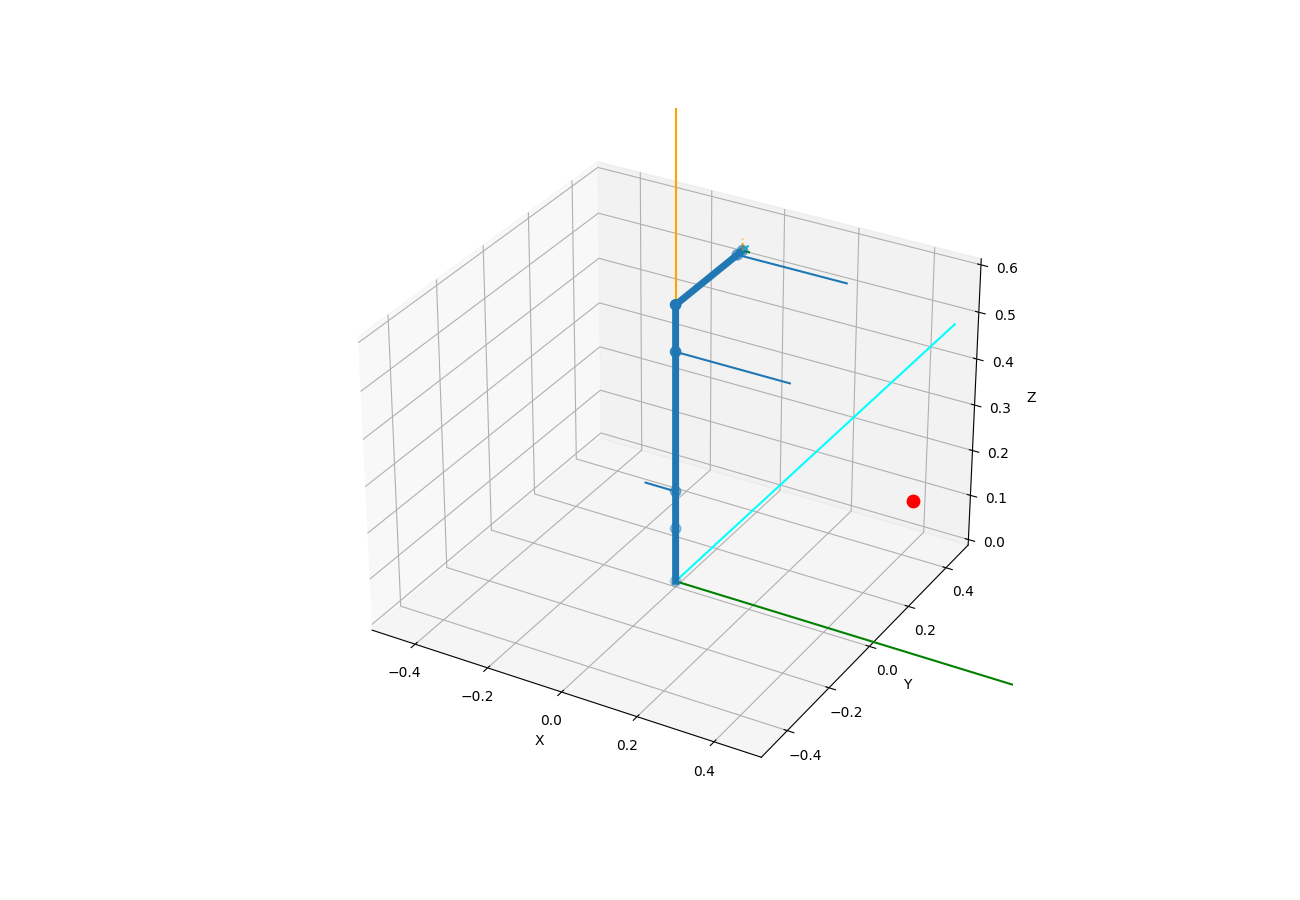

In [57]:
# Optional: support /home/maven/robot_arm_ws/src/robot_arm_description/urdf/temp.urdffor 3D plotting in the NB
# If there is a matplotlib error, uncomment the next line, and comment the line below it.
# %matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
fig.set_figheight(9)
fig.set_figwidth(13)
my_chain.plot(ik, ax, target=target_position)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.set_zlim(0.0, 0.6)
plt.ion()

In [58]:
import serial
import time

arduino = serial.Serial(port='/dev/ttyUSB1', baudrate=115200, timeout=1)

def doIK():
    global ik
    old_position = ik.copy()
    ik=my_chain.inverse_kinematics(target_position, target_orientation,orientation_mode="Z")
    print(ik)
    angles = list(map(lambda r:math.degrees(r), ik.tolist()))
    print(["%.4f" % elem for elem in angles])

def doIK2():
    global ik
    global target_orientation
    global target_position
    old_position = ik.copy()
    ik=my_chain.inverse_kinematics(target_position=target_position, target_orientation=target_orientation,orientation_mode="all")
    print(ik)
    angles = list(map(lambda r:math.degrees(r), ik.tolist()))
    print(["%.4f" % elem for elem in angles])
    
def doFK(a,b,c,d,e,f):
    global ik
    global fk
    target_angles = [math.radians(0.0), math.radians(a),math.radians(b),math.radians(c),math.radians(d),math.radians(e),math.radians(f)]
    print(["%.4f" % elem for elem in target_angles])
    fk=my_chain.forward_kinematics(target_angles)
    print(fk[:3,3])
    print(fk[:3,0])
    print(fk[:3,:3])
    print(fk)
    ik=my_chain.inverse_kinematics(target_position=fk[:3,3], target_orientation=fk[:3,:3], orientation_mode="all")
    angles = list(map(lambda r:math.degrees(r), ik.tolist()))
    # print(["%.2f" % elem for elem in angles])
    # print("Computed position (readable : %s" % ['%.2f' % elem for elem in fk[:3, 3]])
    # print(fk[:3, :3])
    # print("The angles of each joints are %s ", list(map(lambda r:math.degrees(r), ik.tolist())))
    
def updatePlot(data):
  
    
    fig, ax = plot_utils.init_3d_figure()
    my_chain.plot(ik, ax, target=target_position, show=True)
    fig.set_figheight(9)
    fig.set_figwidth(13)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    ax.set_zlim(0.0, 0.6)
    plt.ion()
    ax.legend()


def move2():
    global target_position
    global target_orientation
    global ik
    # target_position = [x,y,z]
    # target_orientation= [math.radians(r1),math.radians(r2),math.radians(r3)]
    print(target_position)
    print(target_orientation)
    doIK2()
    moveJoints(ik[1].item(),ik[2].item(),ik[3].item(),ik[4].item(),ik[5].item(),ik[6].item(),0)
    # updatePlot(ik)
                         
    
def move(x,y,z,r1,r2,r3):
    global target_position
    global target_orientation
    global ik
    target_position = [x,y,z]
    target_orientation= [math.radians(r1),math.radians(r2),math.radians(r3)]
    print(target_position)
    print(target_orientation)
    doIK()
    moveJoints(ik[1].item(),ik[2].item(),ik[3].item(),ik[4].item(),ik[5].item(),ik[6].item(),0)
    # updatePlot(ik)
                                    
def moveFK(a,b,c,d,e,f):
    global fk
    doFK(a,b,c,d,e,f)
    updatePlot(ik)
    moveJoints(ik[1].item(),ik[2].item(),ik[3].item(),ik[4].item(),ik[5].item(),ik[6].item(),0)
                                    

def sendCommand(command, sleep=5):
    print(command.encode('ascii'))
    arduino.write(command.encode('ascii'))
    time.sleep(sleep)
    
def moveJoints(a,b,c,d,e,f,g):
    command = '{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}\r\n'.format(math.degrees(a),math.degrees(b),math.degrees(c),math.degrees(d),math.degrees(e),math.degrees(f),math.degrees(g))
    sendCommand(command)
    
def goHome():
    sendCommand("HOME\r\n")
    
def goInit():
    command = '{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}\r\n'.format(0.0,-55.0,-87.0,0.0,0.0,0.0,10)
    sendCommand(command)
    
def openGripper(steps):
    command = 'GR{0}\r\n'.format(steps)
    sendCommand(command, 3)
    
def resetGripper(steps):
    command = 'RS{0}\r\n'.format(steps)
    sendCommand(command,3)

In [60]:
resetGripper(0)

b'RS0\r\n'


In [62]:
openGripper(0)

b'GR0\r\n'


In [76]:

goInit()

b'0.0000,-55.0000,-87.0000,0.0000,0.0000,0.0000,10.0000\r\n'


In [32]:
goHome()

b'HOME\r\n'


In [19]:
move(0.0,       0.3145,   0.596394,0,0,0) # HOME
# openGripper(1000)
move(0,       0.30,   0.45,0,180,0)
openGripper(1000)
move(0,       0.30,   0.35,0,180,0)
openGripper(100)
move(0,       0.30,   0.45,0,180,0)

move(0.2,       0.30,   0.45,60,90,0)
move(0.2,       0.30,   0.35,60,90,0)
openGripper(1000)
move(0.2,       0.30,   0.45,60,90,0)
move(0.2,       0.30,   0.35,60,90,0)
openGripper(100)
move(0.2,       0.30,   0.45,60,90,0)
move(-0.2,       0.30,   0.45,-60,90,0)
move(-0.2,       0.30,   0.35,-60,90,0)
openGripper(1000)
move(-0.2,       0.30,   0.45,-60,90,0)
move(-0.2,       0.30,   0.35,-60,90,0)
openGripper(100)
move(-0.2,       0.30,   0.45,-60,90,0)
move(0,       0.30,   0.55,0,180,0)
move(0,       0.30,   0.35,0,180,0)
openGripper(1000)
move(0,       0.30,   0.45,0,180,0)
openGripper(0)
move(0.0,       0.3145,   0.56394,0,180,0) # HOME
move(0.0,       0.3145,   0.596394,0,0,0) # HOME
# goInit()



[0.0, 0.0, 0.0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
b'0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000\r\n'
[0.0, 3.141592653589793, 0.0]
['0.00', '-0.00', '-0.76', '-23.81', '0.00', '-66.95', '-0.00']
b'-0.0000,-0.7576,-23.8077,0.0000,-66.9527,-0.0001,0.0000\r\n'
b'GR1000\r\n'
[0.0, 3.141592653589793, 0.0]
['0.00', '0.00', '4.05', '-38.30', '0.00', '-47.65', '-0.00']
b'0.0000,4.0520,-38.2964,0.0000,-47.6488,-0.0000,0.0000\r\n'
b'GR100\r\n'
[0.0, 3.141592653589793, 0.0]
['0.00', '-0.00', '-0.76', '-23.81', '0.00', '-66.95', '-0.00']
b'-0.0000,-0.7576,-23.8077,0.0000,-66.9527,-0.0001,0.0000\r\n'
[1.0471975511965976, 1.5707963267948966, 0.0]
['0.00', '-33.39', '10.68', '-11.47', '-4.48', '-67.94', '1.98']
b'-33.3930,10.6772,-11.4677,-4.4804,-67.9365,1.9840,0.0000\r\n'
[1.0471975511965976, 1.5707963267948966, 0.0]
['0.00', '-33.52', '14.88', '-25.61', '-3.28', '-49.57', '2.31']
b'-33.5162,14.8781,-25.6058,-3.2844,-49.5702,2.3054,0.0000\r\n'
b'GR1000\r\n'
[1.0471975511

In [75]:
move(0.0,       0.3145,   0.596394,0,0,0) # HOME
move(0.0,       0.25,   0.2,0,0,120) # HOME
openGripper(1500)
move(0.0,       0.4,   0.2,0,0,100) # HOME
# move(0.0,       0.5,   0.22,-10,0,100) # HOME
openGripper(0)
move(0.0,       0.4,   0.5,0,0,100) # HOME
move(0.2,       0.4,   0.5,0,0,100) # HOME
move(-0.2,       0.4,   0.5,0,0,100) # HOME
move(0.0,       0.4,   0.2,0,0,100) # HOME
openGripper(1500)
move(0.0,       0.25,   0.2,0,0,120) # HOME
move(0.0,       0.3145,   0.596394,0,0,0) # HOME
openGripper(0)


# move(0.0,       0.5,   0.5,-90,0,100) # HOME
# move(0.0,       0.5,   0.22,-10,0,100) # HOME
# openGripper(1500)
# move(0.0,       0.4,   0.22,-10,0,100) # HOME
# move(0.0,       0.3145,   0.596394,0,0,0) # HOME
# openGripper(0)

[0.0, 0.3145, 0.596394]
[0.0, 0.0, 0.0]
[0. 0. 0. 0. 0. 0. 0.]
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
b'0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000\r\n'
[0.0, 0.25, 0.2]
[0.0, 0.0, 2.0943951023931953]
[ 0.00000000e+00  1.01075879e-03  3.51250569e-01 -1.13449210e+00
  1.01511893e-02  1.48580777e+00 -8.62126805e-04]
['0.0000', '0.0579', '20.1252', '-65.0016', '0.5816', '85.1305', '-0.0494']
b'0.0579,20.1252,-65.0016,0.5816,85.1305,-0.0494,0.0000\r\n'
b'GR1500\r\n'
[0.0, 0.4, 0.2]
[0.0, 0.0, 1.7453292519943295]
[ 0.          0.00984238  0.65417895 -0.55808734  0.16867572  1.21693233
 -0.05899303]
['0.0000', '0.5639', '37.4817', '-31.9760', '9.6644', '69.7251', '-3.3801']
b'0.5639,37.4817,-31.9760,9.6644,69.7251,-3.3801,0.0000\r\n'
b'GR0\r\n'
[0.0, 0.4, 0.5]
[0.0, 0.0, 1.7453292519943295]
[ 0.00000000e+00 -1.02729428e-04  2.34635078e-01 -5.97017023e-02
 -5.66777170e-03  2.94279745e-01  5.42305383e-03]
['0.0000', '-0.0059', '13.4436', '-3.4207', '-0.3247

In [108]:
 # move(0.0,       0.3145,   0.596394,0,0,0) # HOME
# openGripper(400)
# move(0,       0.30,   0.34,0,180,20)
# openGripper(50)
# move(0,       0.30,   0.5,0,180,20)
move(0.2,       0.30,   0.5,60,100,0)

# moveFK(-33.1392,10.8487,-1.9273,-8.1495,-77.0466,-0.3577)
# move(0,       0.30,   0.5,0,180,20)
# move(0,       0.40,   0.5,0,180,20)
# move(0,       0.30,   0.315,0,180,20)
# openGripper(400)
# move(0,       0.30,   0.5,0,180,20)
# openGripper(0)

[0.2, 0.3, 0.5]
[1.0471975511965976, 1.7453292519943295, 0.0]
[ 0.         -0.5783888   0.18934603 -0.03363858 -0.14223478 -1.34471702
 -0.00624385]
['0.00', '-33.14', '10.85', '-1.93', '-8.15', '-77.05', '-0.36']
b'-33.1392,10.8487,-1.9273,-8.1495,-77.0466,-0.3577,0.0000\r\n'


In [71]:
move(0.0,       0.3145,   0.596394,0,0,0) # HOME


target_position = [-0.00287418,  0.29978782,  0.4]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()
openGripper(800)

target_position = [-0.00287418,  0.29978782,  0.340]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()
openGripper(50)


target_position = [0.3, 0.2, 0.5]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()

target_position = [0.3, 0.2, 0.312]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()
openGripper(800)


target_position = [0.3, 0.2, 0.5]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()



target_position = [-0.00287418,  0.29978782,  0.5]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()



target_position = [-0.00287418,  0.29978782,  0.33]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()
openGripper(50)

target_position = [-0.00287418,  0.29978782,  0.5]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()


target_position = [0.3, 0.2, 0.5]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()

target_position = [0.3, 0.2, 0.33]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()

openGripper(800)

target_position = [0.3, 0.2, 0.5]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()

target_position = [-0.00287418,  0.29978782,  0.5]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()

target_position = [-0.00287418,  0.29978782,  0.308]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()
openGripper(50)

target_position = [-0.00287418,  0.29978782,  0.5]
target_orientation =[[ 0.99995404, -0.00162445, -0.00944832],
 [ 0.00958695,  0.16943632,  0.98549451],
 [ 0.,         -0.9855398,   0.16944411]]
move2()

target_position = [0.3, 0.2, 0.5]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()

target_position = [0.3, 0.2, 0.343]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()
openGripper(800)

target_position = [0.3, 0.2, 0.5]
target_orientation =[[-0.19835367 , 0.13290502 , 0.97107779],
 [-0.96408205,  0.15209989, -0.21774163],
 [-0.17663978, -0.97938852,  0.09796178]]
move2()

move(0.0,       0.3145,   0.596394,0,0,0) # HOME
openGripper(0)

[0.0, 0.3145, 0.596394]
[0.0, 0.0, 0.0]
[0. 0. 0. 0. 0. 0. 0.]
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
b'0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000\r\n'
[-0.00287418, 0.29978782, 0.4]
[[0.99995404, -0.00162445, -0.00944832], [0.00958695, 0.16943632, 0.98549451], [0.0, -0.9855398, 0.16944411]]
[ 0.00000000e+00  9.58708705e-03 -3.25640543e-03 -5.73440530e-01
  7.78849512e-10 -8.30346609e-01 -9.81293415e-09]
['0.0000', '0.5493', '-0.1866', '-32.8557', '0.0000', '-47.5754', '-0.0000']
b'0.5493,-0.1866,-32.8557,0.0000,-47.5754,-0.0000,0.0000\r\n'
b'GR800\r\n'
[-0.00287418, 0.29978782, 0.34]
[[0.99995404, -0.00162445, -0.00944832], [0.00958695, 0.16943632, 0.98549451], [0.0, -0.9855398, 0.16944411]]
[ 0.00000000e+00  9.58708705e-03  6.85888352e-02 -7.08336402e-01
  9.84511134e-10 -6.23605496e-01 -1.00867177e-08]
['0.0000', '0.5493', '3.9299', '-40.5847', '0.0000', '-35.7300', '-0.0000']
b'0.5493,3.9299,-40.5847,0.0000,-35.7300,-0.0000,0.0000\r\n'
b'GR50\r

['0.0000', '0.0096', '0.0538', '-0.6888', '0.0000', '-0.6580', '0.0000']
[-0.00287418  0.29978782  0.34979852]
[0.99995404 0.00958695 0.        ]
[[ 0.99995404 -0.00162445 -0.00944832]
 [ 0.00958695  0.16943632  0.98549451]
 [ 0.         -0.9855398   0.16944411]]
[[ 0.99995404 -0.00162445 -0.00944832 -0.00287418]
 [ 0.00958695  0.16943632  0.98549451  0.29978782]
 [ 0.         -0.9855398   0.16944411  0.34979852]
 [ 0.          0.          0.          1.        ]]


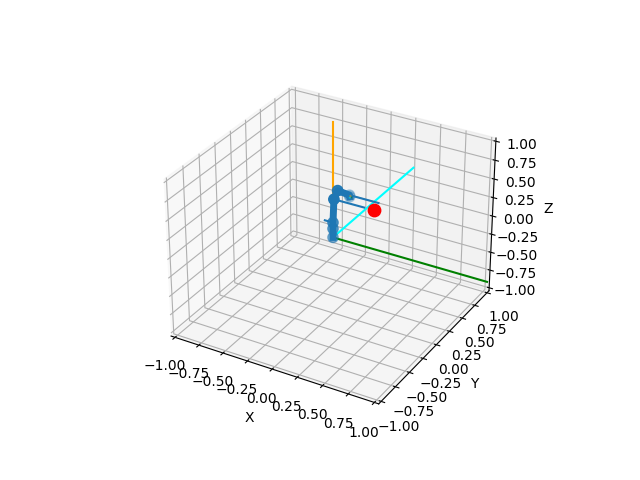

b'0.5493,3.0832,-39.4626,0.0000,-37.6987,-0.0000,0.0000\r\n'


In [208]:
# moveFK(-50.0000, 13.6240, -27.2946, 2.9204, -37.5994, 50)

moveFK( 0.5493, 3.0832, -39.4626, 0, -37.6987, 0)
# moveFK(-45.7078, 13.9721, -26.8589, 0.4246, -36.9942, 34.1682)